# Importing Libraries

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [44]:
def open_file(filename):
    import os
    dir_path = os.path.dirname(os.path.realpath("__file__"))
    isfile = os.path.exists(dir_path + "/"+ filename)
    if not isfile:
        print("File path {} does not exist. Exiting...".format(dir_path + "/"+ filename))
    else :
        with open(filename,"r") as f:
            next(f)
            content = f.readlines()
        content = [x.split("\t") for x in content]
        df = pd.DataFrame(content)     
        df.columns = ['Gx', 'Gy', 'Gz', 'Ax', 'Ay', 'Az', 'ClassLabel', 'StepLabel','None']
        # remove first row
        df =df.reindex(df.index.drop(0))
        # remove last column 'None'
        df = (df.iloc[:,:-1]).astype('float64')
        # removing -1 in stepLabel
        fdf = df.loc[(df['StepLabel']) >-1]
        return fdf.reset_index(drop=True)

In [48]:
raw_df = open_file('T0_Id000000_ActLabelAndStepInfor.txt')

In [49]:
raw_df.head()

,Gx,Gy,Gz,Ax,Ay,Az,ClassLabel,StepLabel
0,-0.088553,0.032715,-0.027293,0.092,-0.814,-0.182,0.0,1.0
1,-0.019311,0.011410,-0.016640,0.092,-0.866,-0.216,0.0,1.0
2,0.044605,0.043368,-0.005988,0.108,-0.900,-0.210,0.0,1.0
3,0.065911,0.027389,-0.000661,0.146,-0.906,-0.220,0.0,1.0
4,0.055258,0.027389,0.025970,0.188,-0.902,-0.216,0.0,1.0


In [50]:
df = raw_df.iloc[:,0:6]

In [51]:
df.head()

,Gx,Gy,Gz,Ax,Ay,Az
0,-0.088553,0.032715,-0.027293,0.092,-0.814,-0.182
1,-0.019311,0.011410,-0.016640,0.092,-0.866,-0.216
2,0.044605,0.043368,-0.005988,0.108,-0.900,-0.210
3,0.065911,0.027389,-0.000661,0.146,-0.906,-0.220
4,0.055258,0.027389,0.025970,0.188,-0.902,-0.216


#### plotting Accelerometer data

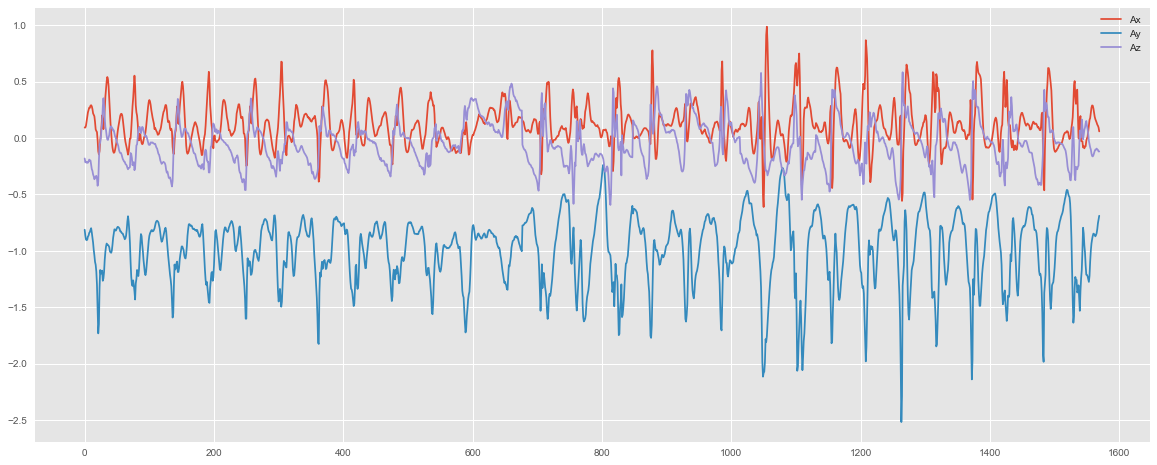

In [107]:
df[['Ax','Ay','Az']].plot(figsize=(20, 8))

#### plotting gyro data

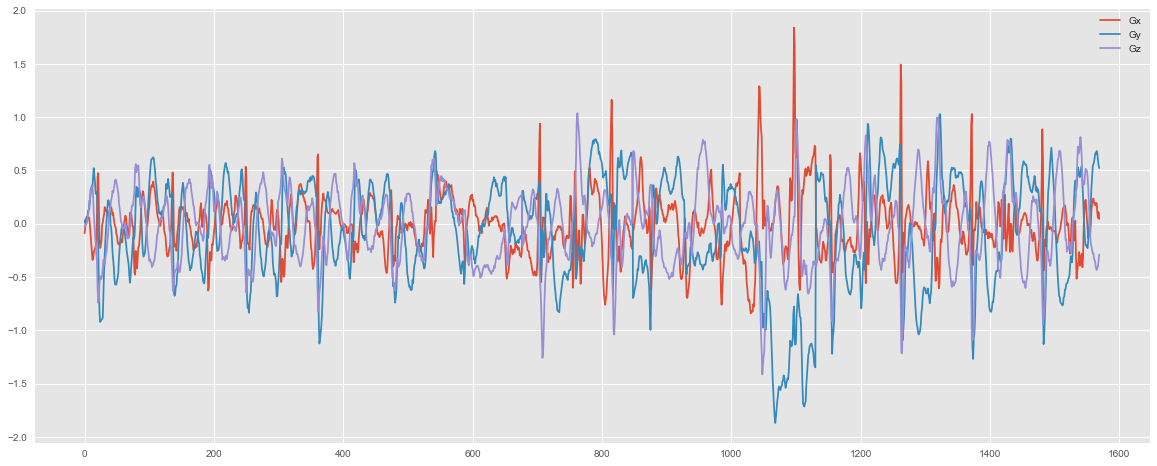

In [106]:
df[['Gx','Gy','Gz']].plot(figsize=(20, 8))

# 1. Filtering

https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform

In [100]:
from scipy import signal
def butter_lowpass(cutoff, nyq_freq, order):
    normal_cutoff = float(cutoff) / nyq_freq
    b, a = signal.butter(order, normal_cutoff, btype='lowpass')
    return b, a

def butter_lowpass_filter(data, cutoff_freq, nyq_freq, order):
    b, a = butter_lowpass(cutoff_freq, nyq_freq, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [103]:
cutoff_frequency = 15.0 # in Hz
x = df['Ay']
sample_rate = 100 # in Hz
y = butter_lowpass_filter(x, cutoff_frequency, sample_rate/2, order = 4)
# Difference acts as a special high-pass from a reversed butterworth filter. 
diff = np.array(x)-np.array(y)

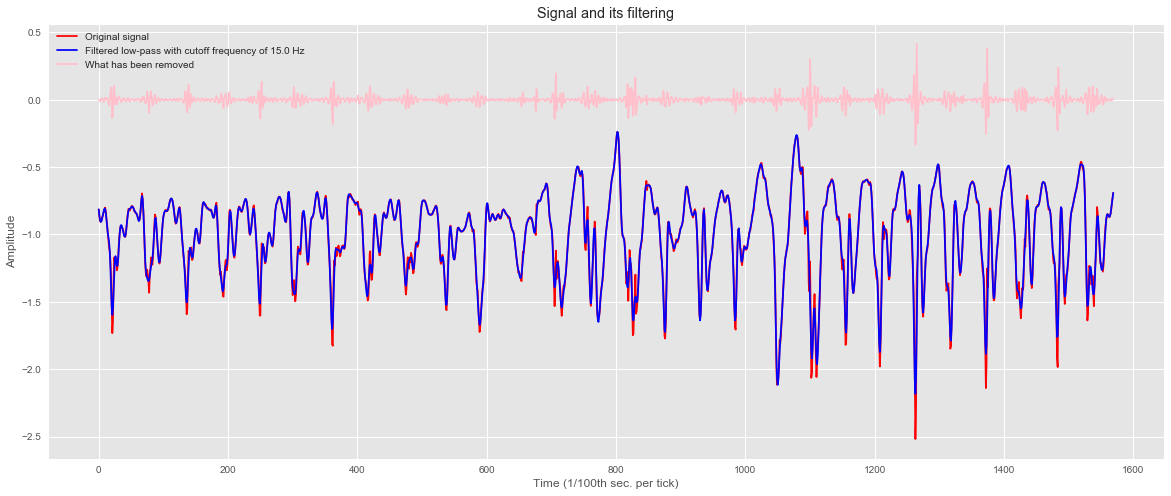

In [108]:
# Visualize
plt.figure(figsize=(20, 8))
plt.plot(x, color='red', label="Original signal")
plt.plot(y, color='blue', label="Filtered low-pass with cutoff frequency of {} Hz".format(cutoff_frequency))
plt.plot(diff, color='pink', label="What has been removed")
plt.title("Signal and its filtering")
plt.xlabel('Time (1/100th sec. per tick)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# 2. Segmentation

In [114]:
# https://stackoverflow.com/questions/45730504/how-do-i-create-a-sliding-window-with-a-50-overlap-with-a-numpy-array

def signal_segmentation(signal, window_size, overlap = 2, copy = False):
    '''
    signal : numpy array or pandas DataFrame
    '''
    sh = (signal.size - window_size + 1, window_size)
    st = signal.strides * 2
    
    view = np.lib.stride_tricks.as_strided(signal, strides = st, shape = sh)[0::overlap]
    if copy:
        return view.copy()
    else:
        return view

In [116]:
a = [1, 2, 3, 4, 5, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
a = np.array(a,dtype = np.float64)
res = signal_segmentation(a, window_size = 5, overlap = 2, copy = True)